In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


In [24]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

In [25]:
print(train_data.shape)
# Each input sample has 13 scalar features
# The targets are the price in k$

(404, 13)


In [26]:
# The input features have heterogenous scales, and we
# should normalize the data to facilitate training
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean)/std
test_data = (test_data - mean)/std
# note the normalization of test_data using train_data's mean and std

In [28]:
# using a function to build model since we will need to instanciate it multiple times
# We are keeping the model small since we don't have a lot of sample to train with
# this helps reducing the impact of overfitting
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1) # We don't use an activation function as we want this
                        # layer to be linear (typical for scalar regression)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    # using mean squared error, typical for regression problems
    # metric MAE: absolute value of diff between predicion and targets
    return model

In [29]:
# Because we have few samples, we're going to use K-fold cross validation
# in order to have more robust metrics

k = 4 
num_val_samples = len(train_data) // k
num_epochs = 100 
all_scores = [] 
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0) # silently train(verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [31]:
print(all_scores, " - mean: ", np.mean(all_scores))
# mean ~2.3, meaning the predictions are on average 2.3k$ off

[1.913401484489441, 2.4732251167297363, 2.637070417404175, 2.3825318813323975]  - mean:  2.3515572249889374


In [32]:
# train with more epochs, and saving val score log for each fold per epoch
num_epochs = 500 
all_mae_histories = [] 
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


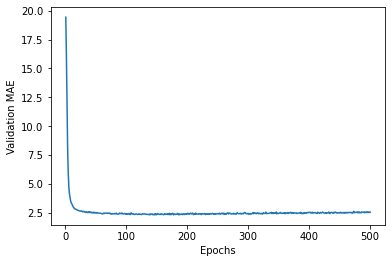

In [38]:
# let's now build the history of mean K-fold val scores, and plot it
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
# plt.yscale('log')
plt.show()

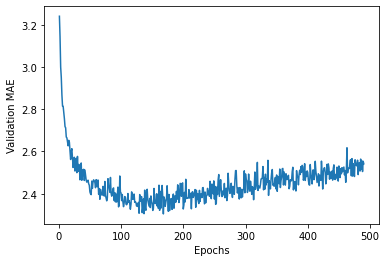

In [39]:
# truncating 10 first values to make y scale clearer
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [41]:
# now that we experimented with params, we can train a final production model
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 1ms/step - loss: 14.7784 - mae: 2.4333


In [46]:
predictions = model.predict(test_data)
for i in range(5):
    print(predictions[i], test_targets[i])

[7.630692] 7.2
[19.387442] 18.8
[21.119703] 19.0
[31.829771] 27.0
[25.24489] 22.2
